In [1]:
!pip install sentence-transformers
!pip install pdfminer.six
!pip install unstructured
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from sentence_transformers import SentenceTransformer
import requests
from urllib.parse import urlparse
from pathlib import Path

[nltk_data] Downloading package punkt to /home/u_244474/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/u_244474/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def create_chunks(text, chunk_size=1024):
    tokens = word_tokenize(text)
    chunks = [' '.join(tokens[i:i+chunk_size]) for i in range(0, len(tokens), chunk_size)]
    return chunks

In [4]:
model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1')

def vectorize_chunks(chunks):
    return model.encode(chunks)                        

In [5]:
from pdfminer.high_level import extract_text

def convert_pdf_to_text(pdf_path):
    text = extract_text(pdf_path)
    return text

pdf_path = 'data/PepsiCo 10k.pdf'
document_text = convert_pdf_to_text(pdf_path)

In [6]:
chunks = create_chunks(document_text, chunk_size=1024)

chunk_vectors = vectorize_chunks(chunks)

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('data/financebench_sample_150.csv')

# Display the first few rows to verify 
print(df.head())

         financebench_id     doc_name  \
0  financebench_id_03029  3M_2018_10K   
1  financebench_id_04672  3M_2018_10K   
2  financebench_id_00499  3M_2022_10K   
3  financebench_id_01226  3M_2022_10K   
4  financebench_id_01865  3M_2022_10K   

                                            doc_link  doc_period  \
0  https://investors.3m.com/financials/sec-filing...        2018   
1  https://investors.3m.com/financials/sec-filing...        2018   
2  https://investors.3m.com/financials/sec-filing...        2022   
3  https://investors.3m.com/financials/sec-filing...        2022   
4  https://investors.3m.com/financials/sec-filing...        2022   

       question_type                                           question  \
0  metrics-generated  What is the FY2018 capital expenditure amount ...   
1  metrics-generated  Assume that you are a public equities analyst....   
2    domain-relevant  Is 3M a capital-intensive business based on FY...   
3    domain-relevant  What drove operating m

In [8]:
# Filter queries for the specific document
pepsico_queries = df[df['doc_name'] == 'PEPSICO_2022_10K']

# Extract the queries and convert them to a list
query_texts = pepsico_queries['question'].tolist()

In [9]:
query_vectors = model.encode(query_texts)

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def retrieve_top_k_chunks_for_all_queries(query_vectors, chunk_vectors, k=5):
    all_top_chunks_indices = []
    for query_vector in query_vectors:
        similarities = cosine_similarity([query_vector], chunk_vectors)[0]
        top_k_indices = similarities.argsort()[-k:][::-1]
        all_top_chunks_indices.append(top_k_indices)
    return all_top_chunks_indices

# Retrieve top-k chunks for all queries
all_top_chunks_indices = retrieve_top_k_chunks_for_all_queries(query_vectors, chunk_vectors, k=5)

In [11]:
def display_top_chunks_for_queries(queries, all_top_chunks_indices, chunks):
    for i, query in enumerate(queries):
        print(f"Query: {query}")
        print("Top Chunks:")
        top_indices = all_top_chunks_indices[i]
        for idx in top_indices:
            print(f"- Chunk {idx}:\n{chunks[idx]}")
        print("\n" + "-"*50 + "\n")

# Assuming 'query_texts' contains the text of your queries
display_top_chunks_for_queries(query_texts, all_top_chunks_indices, chunks)

Query: What are the geographies that Pepsico primarily operates in as of FY2022?
Top Chunks:
- Chunk 205:
States , Delaware Russia Spain United States , Delaware United States , Delaware United States , Delaware Barbados United States , Delaware Uruguay Luxembourg Netherlands United States , Delaware United States , Delaware Cyprus Canada Luxembourg Luxembourg United States , Delaware United States , Delaware Curacao Egypt Netherlands United States , Delaware United States , Delaware Netherlands United States , Delaware Egypt Colombia Egypt Peru Turkey Ireland United States , Delaware United States , Delaware Canada United States , Delaware United States , Delaware China Malaysia Colombia Colombia Bolivia Ecuador Colombia 6 PepsiCo Amacoco Bebidas Do Brasil Ltda . PepsiCo ANZ Holdings Pty Ltd PepsiCo Asia Research & Development Center Company Limited PepsiCo Australia Financing Cyprus Limited PepsiCo Australia Financing Limited Partnership PepsiCo Australia Financing Partner 1 LLC Peps

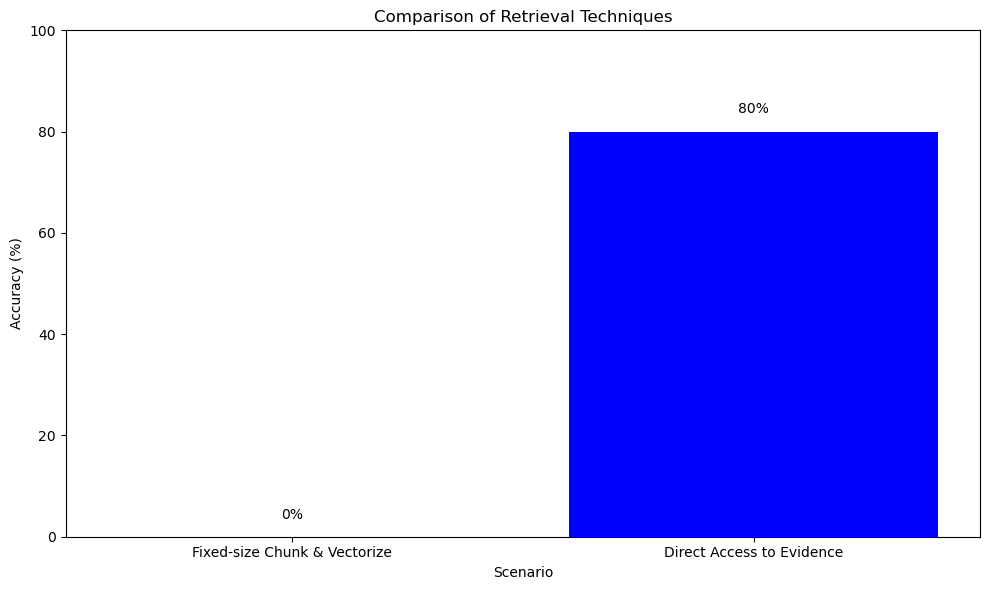

In [12]:
import matplotlib.pyplot as plt

# Data setup
scenarios = ['Fixed-size Chunk & Vectorize', 'Direct Access to Evidence']
accuracies = [0, 80]

# Creating the plot
plt.figure(figsize=(10, 6))
plt.bar(scenarios, accuracies, color=['red', 'blue', 'green'])

# Adding titles and labels
plt.title('Comparison of Retrieval Techniques')
plt.xlabel('Scenario')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Adding text labels above the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 3, f'{accuracy}%', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
# Define the destination folder
dest_folder = './data'
Path(dest_folder).mkdir(exist_ok=True) # Ensure the destination folder exists

def download_document(url, dest_folder, doc_name):
    # Parse the URL to get a meaningful filename
    filename = f"{doc_name}.pdf" if not doc_name.lower().endswith('.pdf') else doc_name

    # Construct the full path where the file will be saved
    filepath = Path(dest_folder) / filename

    # Check if file already exists to avoid re-downloading
    if not filepath.exists():
        try:
            # Make HTTP GET request to download the document
            response = requests.get(url)
            response.raise_for_status() # Ensure the request was succesful

            # Write the document to a file
            with open(filepath, 'wb') as file:
                file.write(response.content)
            print(f"Downloaded {filename} to {dest_folder}")
        except requests.exceptions.RequestException as e: # Catch any request related errors
            print(f"Failed to download {url}. Error: {e}")
    else:
        print(f"{filename} already exists in {dest_folder}")

# Load the dataset
df = pd.read_csv('data/financebench_sample_150.csv')

# Download documents
for _, row in df.iterrows():
    if pd.notna(row['doc_link']) and pd.notna(row['doc_name']):
        download_document(row['doc_link'], dest_folder, row['doc_name'])

3M_2018_10K.pdf already exists in ./data
3M_2018_10K.pdf already exists in ./data
3M_2022_10K.pdf already exists in ./data
3M_2022_10K.pdf already exists in ./data
3M_2022_10K.pdf already exists in ./data
3M_2023Q2_10Q.pdf already exists in ./data
3M_2023Q2_10Q.pdf already exists in ./data
3M_2023Q2_10Q.pdf already exists in ./data
ACTIVISIONBLIZZARD_2019_10K.pdf already exists in ./data
ACTIVISIONBLIZZARD_2019_10K.pdf already exists in ./data
ADOBE_2015_10K.pdf already exists in ./data
ADOBE_2016_10K.pdf already exists in ./data
ADOBE_2017_10K.pdf already exists in ./data
ADOBE_2022_10K.pdf already exists in ./data
ADOBE_2022_10K.pdf already exists in ./data
AES_2022_10K.pdf already exists in ./data
AES_2022_10K.pdf already exists in ./data
AES_2022_10K.pdf already exists in ./data
AMAZON_2017_10K.pdf already exists in ./data
AMAZON_2017_10K.pdf already exists in ./data
AMAZON_2019_10K.pdf already exists in ./data
AMCOR_2020_10K.pdf already exists in ./data
AMCOR_2022_8K_dated-2022-07

In [14]:
# Create a Path object
dest_path = Path(dest_folder)

# List all PDF files in the destination folder
downloaded_files = [file.name for file in dest_path.iterdir() if file.suffix == '.pdf']

# Print the number of downloaded files
print(f"Number of downloaded files: {len(downloaded_files)}")

Number of downloaded files: 80


In [15]:
import os

pdf_folder_path = 'data/reports'
extracted_texts_path = os.path.join(pdf_folder_path, "extracted_texts")
document_texts = {}

# Ensure the directory for extracted texts exists
os.makedirs(extracted_texts_path, exist_ok=True)

for doc_name in df['doc_name'].unique():
    pdf_path = os.path.join(pdf_folder_path, f"{doc_name}.pdf")
    output_text_path = os.path.join(extracted_texts_path, f"{doc_name}.txt")

    # Check if the PDF file exists before proceeding
    if os.path.exists(pdf_path):
    
        # Check if the text has already been extracted and saved
        if not os.path.exists(output_text_path):  # If not, extract and save
            print(f"Extracting text from {pdf_path}")
            document_text = convert_pdf_to_text(pdf_path)
            with open(output_text_path, 'w', encoding='utf-8') as text_file:
                text_file.write(document_text)
            print(f"Text saved to {output_text_path}")
        else:
            print(f"Text already extracted for {doc_name}")
    
        # Load the extracted text into memory
        with open(output_text_path, 'r', encoding='utf-8') as text_file:
            document_texts[doc_name] = text_file.read()

    else:
        print(f"PDF file does not exist: {pdf_path}")

Text already extracted for 3M_2018_10K
Text already extracted for 3M_2022_10K
Text already extracted for 3M_2023Q2_10Q
Text already extracted for ACTIVISIONBLIZZARD_2019_10K
Text already extracted for ADOBE_2015_10K
Text already extracted for ADOBE_2016_10K
Text already extracted for ADOBE_2017_10K
Text already extracted for ADOBE_2022_10K
Text already extracted for AES_2022_10K
Text already extracted for AMAZON_2017_10K
Text already extracted for AMAZON_2019_10K
Text already extracted for AMCOR_2020_10K
Text already extracted for AMCOR_2022_8K_dated-2022-07-01
Text already extracted for AMCOR_2023_10K
Text already extracted for AMCOR_2023Q2_10Q
Text already extracted for AMCOR_2023Q4_EARNINGS
Text already extracted for AMD_2015_10K
Text already extracted for AMD_2022_10K
Text already extracted for AMERICANEXPRESS_2022_10K
Text already extracted for AMERICANWATERWORKS_2020_10K
Text already extracted for AMERICANWATERWORKS_2021_10K
Text already extracted for AMERICANWATERWORKS_2022_10K


In [16]:
extracted_files_count = len([name for name in os.listdir(extracted_texts_path) if os.path.isfile(os.path.join(extracted_texts_path, name))])
print(f"Number of extracted text files: {extracted_files_count}")

Number of extracted text files: 80


In [17]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['doc_name_encoded'] = encoder.fit_transform(df['doc_name'])

In [18]:
from sklearn.model_selection import train_test_split

X = df['question'] # Features
y = df['doc_name_encoded'] # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [20]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [21]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.13333333333333333


In [22]:
import random

# Sample 5 random rows from the dataframe
sample_questions = df.sample(n=5)

# Print the selected questions and their doc_name
for index, row in sample_questions.iterrows():
    print(f"Question: {row['question']}")
    print(f"Document Name: {row['doc_name']}\n")

Question: We need to calculate a financial metric by using information only provided within the balance sheet. Please answer the following question: what is Boeing's year end FY2018 net property, plant, and equipment (in USD millions)?
Document Name: BOEING_2018_10K

Question: What are the geographies that American Express primarily operates in as of 2022?
Document Name: AMERICANEXPRESS_2022_10K

Question: As of FY 2021, how much did Verizon expect to pay for its retirees in 2024?
Document Name: VERIZON_2021_10K

Question: What is the FY2019 fixed asset turnover ratio for Activision Blizzard? Fixed asset turnover ratio is defined as: FY2019 revenue / (average PP&E between FY2018 and FY2019). Round your answer to two decimal places. Base your judgments on the information provided primarily in the statement of income and the statement of financial position.
Document Name: ACTIVISIONBLIZZARD_2019_10K

Question: As of May 26, 2023, what is the total amount Pepsico may borrow under its unse

In [23]:
!pip install spacy
!python -m spacy download en_core_web_sm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.5 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [24]:
encoder = LabelEncoder()
df['doc_name_encoded'] = encoder.fit_transform(df['doc_name'])

In [25]:
import spacy
from sklearn.pipeline import Pipeline

# Load Spacy's NLP model
nlp = spacy.load("en_core_web_sm")

def extract_keywords_with_ner(text):
    # Process the text with Spacy NLP pipeline
    doc = nlp(text)

    # Extract entities identified by Spacy NER
    keywords = [ent.text for ent in doc.ents if ent.label_ in ["ORG"]]

    # Join keywords for TF-IDF vectorization
    keywords_str = ' '.join(keywords)
    return keywords_str

# Apply keyword extraction on questions
df['question_keywords'] = df['question'].apply(extract_keywords_with_ner)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['question_keywords'], df['doc_name_encoded'], test_size=0.2, random_state=42)

# Creating a TF-IDF Vectorizer to convert the questions into vectors
tfidf_vectorizer = TfidfVectorizer()

# Creating a Logistic Regression model
logistic_regression_model = LogisticRegression(max_iter=1000)

# Creating a pipeline that first converts texts to vectors and then applies logistic regression
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('logistic_regression', logistic_regression_model)
])

# Training the pipeline
pipeline.fit(X_train, y_train)

# Testing the model
accuracy = pipeline.score(X_test, y_test)
print(f'Model Accuracy: {accuracy}')

# Predicting document names
predicted_doc_names_encoded = pipeline.predict(X_test)
predicted_doc_names = encoder.inverse_transform(predicted_doc_names_encoded)

# Example of displaying a few predictions
for i, (question, prediction) in enumerate(zip(X_test[:5], predicted_doc_names[:5])):
    print(f"Question: {question}\nPredicted Document Name: {prediction}\n{'-'*60}")


Model Accuracy: 0.13333333333333333
Question: Corning FY2022
Predicted Document Name: PEPSICO_2022_10K
------------------------------------------------------------
Question: Amazon DPO DPO FY2017 FY2017 P&L
Predicted Document Name: AMERICANEXPRESS_2022_10K
------------------------------------------------------------
Question: FY2022
Predicted Document Name: PEPSICO_2022_10K
------------------------------------------------------------
Question: CVS Health FY2022
Predicted Document Name: PEPSICO_2022_10K
------------------------------------------------------------
Question: FY2022
Predicted Document Name: PEPSICO_2022_10K
------------------------------------------------------------


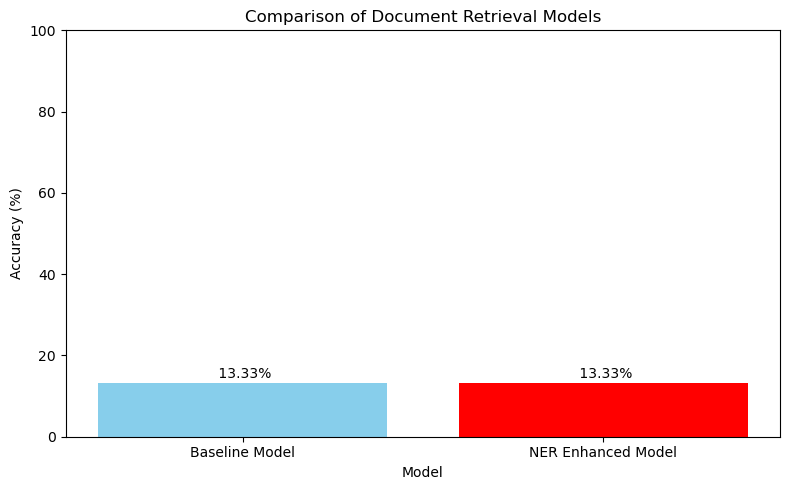

In [27]:
# Data setup
scenarios = ['Baseline Model', 'NER Enhanced Model']
accuracies = [13.333333, 13.333333]

# Creating the plot
plt.figure(figsize=(8, 5))
plt.bar(scenarios, accuracies, color=['skyblue', 'red'])

# Adding titles and labels
plt.title('Comparison of Document Retrieval Models')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Adding text labels above the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.5, f'{accuracy: .2f}%', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

In [28]:
!pip install openai

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [5]:
import openai

# Set up API key
openai.api_key = os.getenv("OPENAI_API_KEY")

In [6]:
client = openai.OpenAI(api_key=openai.api_key)

In [31]:
def format_doc_name(data):
    try:
        json_data = eval(data)
        return f"{json_data['company']}_{json_data['year']}_{json_data['financial_report_type'].replace('-', '')}.pdf"
    except Exception as e:
        print(f"Error formatting document name: {e}")
        return None

In [32]:
X = df['question']
y = df['doc_name']

In [69]:
import json

def find_financial_report(question):
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            response_format={"type": "json_object"},
            messages=[
                {"role": "system", "content": "You are a financial analyst. Return information in JSON format with the relevant fields of company, year, and financial report type."},
                {"role": "user", "content": f"Which standard financial report (e.g., 10-K, 10-Q, 8-K) typically contains the information needed to answer this question: '{question}'?"}
            ]
        )
        # Extract and return the JSON formatted text from the response
        return response.choices[0].message.content
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def format_doc_name(data):
    try:
        json_data = json.loads(data)
        
        # Normalize the company name
        company = json_data.get('company', 'Unknown').replace(' ', '').replace('(', '').replace(')', '')

        # Handle the year and report type formatting
        year = json_data.get('year', 'Unknown')
        if isinstance(year, list):
            year = max(year, key=lambda x: int(x.replace('FY', '').replace('Q', '').split(' ')[0]))  # Get the latest year
        year = str(year).replace('FY', '')  # Clean up any fiscal year notation

        # Handle quarterly data
        if 'Q' in year:
            parts = year.split('Q')
            year = parts[0] + 'Q' + parts[1]

        financial_report_type = json_data.get('financial_report_type', '').replace('-', '')
        
        # Normalize the year to four digits
        if len(year) == 2:  # Handle cases like '22' for 2022
            year = '20' + year

        return f"{company}_{year}_{financial_report_type}"
    except Exception as e:
        print(f"Error in format_doc_name: {e}")
        return None

def get_predictions(questions):
    predictions = []
    for question in questions:
        print(f"Processing question: {question}")
        report_type = find_financial_report(question)
        if report_type:
            print(f"Report type found: {report_type}")
            doc_name = format_doc_name(report_type)
            if doc_name:
                predictions.append(doc_name)
                print(f"Formatted document name: {doc_name}")  # Print the document name here
            else:
                predictions.append('Formatting error')
                print("Formatting error")  # Indicate a formatting error
        else:
            predictions.append('Unknown')
            print("Unknown report type")  # Indicate that no report type was found
    return predictions

In [70]:
# Sample 5 random rows from the dataframe
sample_questions = df.sample(n=30)

# Print the selected questions and their doc_name
for index, row in sample_questions.iterrows():
    print(f"Question: {row['question']}")
    print(f"Document Name: {row['doc_name']}\n")

# Extract only the question text to send to the prediction function
question_texts = sample_questions['question'].tolist()
actual_names = sample_questions['doc_name'].tolist()

# Debug print to check what questions are being sent to the prediction function
print("Questions being processed:", question_texts)

y_pred_sample = get_predictions(question_texts)
print("Sample Predictions:", y_pred_sample)

Question: How much has the effective tax rate of American Express changed between FY2021 and FY2022?
Document Name: AMERICANEXPRESS_2022_10K

Question: Which type of debt received the largest investment among the short term investments for MGM in H1 FY2023?
Document Name: MGMRESORTS_2023Q2_10Q

Question: How did JnJ's US sales growth compare to international sales growth in FY2022?
Document Name: JOHNSON&JOHNSON_2022Q4_EARNINGS

Question: Using only the information within the balance sheet, how much total assets did Costco have at the end of FY2021? Answer in USD millions.
Document Name: COSTCO_2021_10K

Question: What is Lockheed Martin's FY2021 net working capital? Define net working capital as total current assets less total current liabilities. Answer in USD millions. Respond to the question by assuming the perspective of an investment analyst who can only use the details shown within the balance sheet.
Document Name: LOCKHEEDMARTIN_2021_10K

Question: Which debt securities are reg

In [71]:
# Actual and Predicted document names
actual_names = [
    "AMERICANEXPRESS_2022_10K", "MGMRESORTS_2023Q2_10Q", "JOHNSON&JOHNSON_2022Q4_EARNINGS",
    "COSTCO_2021_10K", "LOCKHEEDMARTIN_2021_10K", "3M_2023Q2_10Q",
    "CORNING_2020_10K", "Pfizer_2023Q2_10Q", "ADOBE_2022_10K",
    "LOCKHEEDMARTIN_2022_10K", "PEPSICO_2023_8K_dated-2023-05-05", "ADOBE_2022_10K",
    "AMD_2022_10K", "WALMART_2018_10K", "GENERALMILLS_2020_10K",
    "PFIZER_2021_10K", "PEPSICO_2021_10K", "BOEING_2018_10K",
    "VERIZON_2022_10K", "AMD_2022_10K", "3M_2023Q2_10Q",
    "AMCOR_2023Q2_10Q", "VERIZON_2022_10K", "JPMORGAN_2021Q1_10Q",
    "NIKE_2023_10K", "AES_2022_10K", "NIKE_2019_10K",
    "PEPSICO_2023Q1_EARNINGS", "AMERICANEXPRESS_2022_10K", "BESTBUY_2023_10K"
]

predicted_names = [
    "AmericanExpress_2022_10K", "MGM_H1 2023_10Q", "Johnson&JohnsonJnJ_2022_10K", 
    "Costco_2021_10K", "LockheedMartin_2021_10K", "3M_2023_10Q",
    "Corning_Unknown_", "Pfizer_current or upcoming fiscal year_10K", "Adobe_2022_10K",
    "LockheedMartin_2020-2022_10K", "Pepsico_2023_proxy statement (DEF 14A)", "Adobe_2022_10K",
    "AMD_2022_10K", "Walmart_2018_10K", "GeneralMills_2020_",
    "Pfizer_2019_10K", "PepsiCo_2021_10K", "Boeing_2018_10K",
    "Verizon_2022_10K", "AMD_2022_10K", "3M_2023_10Q",
    "AMCOR_2023_10Q", "Verizon_2022_10K", "JPMorganChase&Co.JPM_2021_10Q",
    "Nike_2023_10K", "AESCorporation_2022_10K", "Nike_2019_10K",
    "Pepsico_2023_8K", "AmericanExpress_2022_10K", "BestBuy_Unknown_"
]

# Normalizing both lists to ensure case and spacing are not an issue
actual_names_normalized = [name.replace(" ", "").upper() for name in actual_names]
predicted_names_normalized = [name.replace(" ", "").upper() for name in predicted_names]

# Calculating accuracy
correct_predictions = sum(1 for actual, predicted in zip(actual_names_normalized, predicted_names_normalized) if actual == predicted)
total_predictions = len(actual_names)
accuracy_percentage = (correct_predictions / total_predictions) * 100

print(f"Correct Predictions: {correct_predictions}")
print(f"Total Predictions: {total_predictions}")
print(f"Accuracy: {accuracy_percentage:.2f}%")

Correct Predictions: 15
Total Predictions: 30
Accuracy: 50.00%


In [20]:
import re

def find_relevant_document(question, doc_names):
    try:
        doc_list = ', '.join(doc_names)  # List of all document names

        prompt = f"Given these financial documents: {doc_list}, which should be used to answer the question: '{question}'?"
        print("Prompt sent to model:", prompt)

        response = client.chat.completions.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You are a financial analyst. Decide which financial document to use."},
                {"role": "user", "content": prompt}
            ]
        )

        predicted_report = response.choices[0].message.content.strip()
        print("Predicted Report:", predicted_report)

        # Dynamic regex pattern based on document names
        doc_names_regex = '|'.join(re.escape(doc) for doc in doc_names)
        pattern = rf'({doc_names_regex})'
        match = re.search(pattern, predicted_report)
        matched_document = match.group(1) if match else None

        if matched_document:
            print("Matched Document:", matched_document)
        else:
            print("No matching document found.")

        return matched_document

    except Exception as e:
        print(f"An error occurred while finding the relevant document: {e}")
        return None

def test_document_matching(df, num_samples=30):
    samples = df.sample(n=num_samples)
    
    # Collect all document names from the DataFrame to provide as options
    all_doc_names = df['doc_name'].unique().tolist()

    for index, sample in samples.iterrows():
        question = sample['question']
        actual_doc_name = sample['doc_name'].strip()

        predicted_doc_name = find_relevant_document(question, all_doc_names)  # Pass all possible documents

        is_correct = predicted_doc_name == actual_doc_name
        status = "Correct" if is_correct else "Incorrect"

        print(f"Question: {question}")
        print(f"Predicted Document: {predicted_doc_name}")
        print(f"Actual Document: {actual_doc_name}")
        print(f"Status: {status}")

# Example usage
num_questions_to_test = 30  # Adjust the number of tests as needed
test_document_matching(df, num_questions_to_test)

Prompt sent to model: Given these financial documents: 3M_2018_10K, 3M_2022_10K, 3M_2023Q2_10Q, ACTIVISIONBLIZZARD_2019_10K, ADOBE_2015_10K, ADOBE_2016_10K, ADOBE_2017_10K, ADOBE_2022_10K, AES_2022_10K, AMAZON_2017_10K, AMAZON_2019_10K, AMCOR_2020_10K, AMCOR_2022_8K_dated-2022-07-01, AMCOR_2023_10K, AMCOR_2023Q2_10Q, AMCOR_2023Q4_EARNINGS, AMD_2015_10K, AMD_2022_10K, AMERICANEXPRESS_2022_10K, AMERICANWATERWORKS_2020_10K, AMERICANWATERWORKS_2021_10K, AMERICANWATERWORKS_2022_10K, BESTBUY_2017_10K, BESTBUY_2019_10K, BESTBUY_2023_10K, BESTBUY_2024Q2_10Q, BLOCK_2016_10K, BLOCK_2020_10K, BOEING_2018_10K, BOEING_2022_10K, COCACOLA_2017_10K, COCACOLA_2021_10K, COCACOLA_2022_10K, CORNING_2020_10K, CORNING_2021_10K, CORNING_2022_10K, COSTCO_2021_10K, CVSHEALTH_2018_10K, CVSHEALTH_2022_10K, FOOTLOCKER_2022_8K_dated_2022-08-19, FOOTLOCKER_2022_8K_dated-2022-05-20, GENERALMILLS_2019_10K, GENERALMILLS_2020_10K, GENERALMILLS_2022_10K, JOHNSON&JOHNSON_2022_10K, JOHNSON&JOHNSON_2022Q4_EARNINGS, JOHNSON

In [ ]:
Accuracy: 24/30

In [25]:
def find_relevant_document(question, doc_names):
    try:
        doc_list = ', '.join(doc_names)  # List of all document names

        prompt = f"Given these financial documents: {doc_list}, which should be used to answer the question: '{question}'?"
        print("Prompt sent to model:", prompt)

        response = client.chat.completions.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You are a financial analyst. Decide which financial document to use."},
                {"role": "user", "content": prompt}
            ]
        )

        predicted_report = response.choices[0].message.content.strip()
        print("Predicted Report:", predicted_report)  # Debugging output

        # Dynamic regex pattern to extract document names and their years/quarters
        doc_names_regex = '|'.join(re.escape(doc) for doc in doc_names)
        pattern = rf'({doc_names_regex})'
        matches = re.findall(pattern, predicted_report)
        
        if matches:
            # Parse years and sort documents by recency
            def extract_year(doc):
                match = re.search(r'(\d{4})', doc)
                return int(match.group(1)) if match else 0

            sorted_docs = sorted(matches, key=extract_year, reverse=True)
            matched_document = sorted_docs[0] if sorted_docs else None
            print("Matched Document:", matched_document)
        else:
            matched_document = None
            print("No matching document found.")

        return matched_document

    except Exception as e:
        print(f"An error occurred while finding the relevant document: {e}")
        return None

def test_document_matching(df, num_samples=30):
    samples = df.sample(n=num_samples)
    all_doc_names = df['doc_name'].unique().tolist()

    for index, sample in samples.iterrows():
        question = sample['question']
        predicted_doc_name = find_relevant_document(question, all_doc_names)
        actual_doc_name = sample['doc_name'].strip()

        is_correct = predicted_doc_name == actual_doc_name
        status = "Correct" if is_correct else "Incorrect"

        print(f"Question: {question}")
        print(f"Predicted Document: {predicted_doc_name}")
        print(f"Actual Document: {actual_doc_name}")
        print(f"Status: {status}")

# Example usage
num_questions_to_test = 30  # Adjust the number of tests as needed
test_document_matching(df, num_questions_to_test)

Prompt sent to model: Given these financial documents: 3M_2018_10K, 3M_2022_10K, 3M_2023Q2_10Q, ACTIVISIONBLIZZARD_2019_10K, ADOBE_2015_10K, ADOBE_2016_10K, ADOBE_2017_10K, ADOBE_2022_10K, AES_2022_10K, AMAZON_2017_10K, AMAZON_2019_10K, AMCOR_2020_10K, AMCOR_2022_8K_dated-2022-07-01, AMCOR_2023_10K, AMCOR_2023Q2_10Q, AMCOR_2023Q4_EARNINGS, AMD_2015_10K, AMD_2022_10K, AMERICANEXPRESS_2022_10K, AMERICANWATERWORKS_2020_10K, AMERICANWATERWORKS_2021_10K, AMERICANWATERWORKS_2022_10K, BESTBUY_2017_10K, BESTBUY_2019_10K, BESTBUY_2023_10K, BESTBUY_2024Q2_10Q, BLOCK_2016_10K, BLOCK_2020_10K, BOEING_2018_10K, BOEING_2022_10K, COCACOLA_2017_10K, COCACOLA_2021_10K, COCACOLA_2022_10K, CORNING_2020_10K, CORNING_2021_10K, CORNING_2022_10K, COSTCO_2021_10K, CVSHEALTH_2018_10K, CVSHEALTH_2022_10K, FOOTLOCKER_2022_8K_dated_2022-08-19, FOOTLOCKER_2022_8K_dated-2022-05-20, GENERALMILLS_2019_10K, GENERALMILLS_2020_10K, GENERALMILLS_2022_10K, JOHNSON&JOHNSON_2022_10K, JOHNSON&JOHNSON_2022Q4_EARNINGS, JOHNSON

In [ ]:
Accuracy: 25/30